In [1]:
!ls

Explore Holzer 2021 Fluxes.ipynb OCIM2_48L_base_transport.mat
OCIM2_48L_base_data.nc


In [59]:
from scipy.io import loadmat

#Units of "per year" for the transport matrix
base_transport = loadmat("OCIM2_48L_base_transport.mat")

In [60]:
base_transport

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Wed Jun 16 15:43:51 2021',
 '__version__': '1.0',
 '__globals__': [],
 'TR': <405386x405386 sparse matrix of type '<class 'numpy.float64'>'
 	with 6225475 stored elements in Compressed Sparse Column format>}

In [2]:
from netCDF4 import Dataset

In [45]:
data = Dataset("OCIM2_48L_base_data.nc")

<class 'netCDF4._netCDF4.Variable'>
float64 ocnmask(depth, longitude, latitude)
    description: land-sea mask (1 = ocean, 0 = land)
unlimited dimensions: 
current shape = (48, 180, 91)
filling on, default _FillValue of 9.969209968386869e+36 used
405386.0
(array([ 0,  0,  0, ..., 47, 47, 47]), array([  0,   0,   0, ..., 151, 151, 151]), array([ 9, 10, 11, ..., 57, 58, 59]))


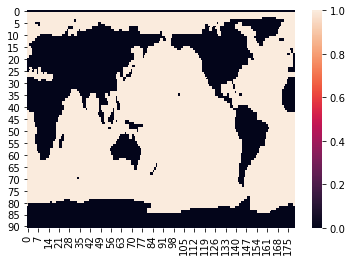

In [43]:
import numpy as np
print(data.variables['ocnmask'])
type(data.variables['ocnmask'][:].data)
print(np.sum(data.variables['ocnmask'][:].data))
print(np.nonzero(data.variables['ocnmask'][:].data))

from matplotlib import pyplot as plt
import seaborn as sns
sns.heatmap(data.variables['ocnmask'][0].data[:,::-1].transpose())

In [86]:
ocnmask = data.variables['ocnmask']
ocnmask.shape

(48, 180, 91)

In [99]:
#figure out the index mapping from tr idx to full grid points via np.nonzero on ocean mask
tridx_to_fullgrid_idxs = np.nonzero(ocnmask[:].data)

#Let's populat a data structure called 'gridflux' that's as follows:
# [from_depthidx, from_lonidx, from_latidx] -> [trentry...]
# Where 'trentry' looks like (flux, (to_depthidx, to_lonidx, to_latidx))

#initialize the gridflux data structure
gridflux = []
for depth_idx in range(ocnmask.shape[0]):
    gridflux_depthentry = []
    for lon_idx in range(ocnmask.shape[1]):
        gridflux_lonentry = []
        for lat_idx in range(ocnmask.shape[2]):
            gridflux_latentry = []
            gridflux_lonentry.append(gridflux_latentry)
        gridflux_depthentry.append(gridflux_lonentry)
    gridflux.append(gridflux_depthentry)

TR_mat_coo = base_transport['TR'][fluxaxis_surfacemask][:,fluxaxis_surfacemask].tocoo()
tr_cols, tr_rows, tr_data = TR_mat_coo.col, TR_mat_coo.row, TR_mat_coo.data
for (tr_col, tr_row, flux) in zip(tr_cols, tr_rows, tr_data):
    from_depthidx = tridx_to_fullgrid_idxs[0][tr_row] #need to verify from & to by visualizing
    from_lonidx = tridx_to_fullgrid_idxs[1][tr_row]
    from_latidx = tridx_to_fullgrid_idxs[2][tr_row]
    
    to_depthidx = tridx_to_fullgrid_idxs[0][tr_col]
    to_lonidx = tridx_to_fullgrid_idxs[1][tr_col]
    to_latidx = tridx_to_fullgrid_idxs[2][tr_col]

    #Make sure that the 'to' boxes are adjacent to the 'from' boxes
    assert ((abs(to_depthidx-from_depthidx) <= 1) or
            (max(to_depthidx,from_depthidx)==(ocnmask.shape[0]-1) 
             and min(to_depthidx,from_depthidx)==0)), (to_depthidx, from_depthidx)
    assert ((abs(to_lonidx-from_lonidx) <= 1) or
            (max(to_lonidx,from_lonidx)==(ocnmask.shape[1]-1) 
             and min(to_lonidx,from_lonidx)==0)), (to_lonidx, from_lonidx)
    assert ((abs(to_latidx-from_latidx) <= 1) or
            (max(to_latidx,from_latidx)==(ocnmask.shape[2]-1) 
             and min(to_latidx,from_latidx)==0)), (to_latidx, from_latidx)
    
    gridflux[from_depthidx][from_lonidx][from_latidx].append( (flux, (to_depthidx, to_lonidx, to_latidx)) )
    


#and MOC

#then retrieve lat, lon, depth, pdens? (for uv vector?) for the flux axis
#then pick a box for the target...backtrack source?

In [84]:
len(base_transport['TR'][fluxaxis_surfacemask][:,fluxaxis_surfacemask].tocoo().col)

50564

In [63]:
np.nonzero(fluxaxis_surfacemask)[0]

array([    0,     1,     2, ..., 10439, 10440, 10441])

In [33]:
data.variables

{'ocnmask': <class 'netCDF4._netCDF4.Variable'>
 float64 ocnmask(depth, longitude, latitude)
     description: land-sea mask (1 = ocean, 0 = land)
 unlimited dimensions: 
 current shape = (48, 180, 91)
 filling on, default _FillValue of 9.969209968386869e+36 used,
 'tlat': <class 'netCDF4._netCDF4.Variable'>
 float64 tlat(depth, longitude, latitude)
     description: latitude (degrees north) defined at tracer grid point
 unlimited dimensions: 
 current shape = (48, 180, 91)
 filling on, default _FillValue of 9.969209968386869e+36 used,
 'tlon': <class 'netCDF4._netCDF4.Variable'>
 float64 tlon(depth, longitude, latitude)
     description: longitude (degrees east) defined at tracer grid point
 unlimited dimensions: 
 current shape = (48, 180, 91)
 filling on, default _FillValue of 9.969209968386869e+36 used,
 'tz': <class 'netCDF4._netCDF4.Variable'>
 float64 tz(depth, longitude, latitude)
     description: depth (m below sea surface) defined at tracer grid point
 unlimited dimensions: 